In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import random
from torchvision import transforms
import shutil
from PIL import Image
from glob import glob
import os , itertools

import matplotlib
import matplotlib.pyplot as plt

# Hyperparameter

In [4]:
print('Num_GPU :', torch.cuda.device_count())

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor

params = {
    'batch_size':70 * torch.cuda.device_count(),
    'test_batch_size':1,
    'input_size':128,
    'resize_scale':158,
    'crop_size':128,
    'fliplr':True,
    #model params
    'epoch_count':1,
    'epochs':400,
    'log_interval':4,
    'input_nc':3,
    'output_nc':3,
    'ngf':64,
    'ndf':64,
    'lr':0.0002,    #learning rate for generator
    'lamb':100,
    'alpha':3,
    'beta1':0.5,
    'lr_policy':'lamda',
    'lr_decay_iters':50,
    'dataroot':'C:/Users/IVCL/Desktop/duck_blender2',
}

Num_GPU : 2


# Utils

In [5]:
def to_np(x):
    return x.data.cpu().numpy()
        
def plot_train_result(test_image, epoch, save=False,  show=True, fig_size=(10, 10)):
    plt.figure(figsize=fig_size)
    imgs = [to_np(test_image[0]), to_np(test_image[1]), to_np(test_image[2])]
    title = ['test A', 'test B', 'fake B']
        
    for i in range(0,3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        img = imgs[i]
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')

    # save figure
    if save:
        save_fn = './img_per_epoch/epoch_{:d}'.format(epoch+1) + '.png'
        fig.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

# Model

In [6]:
class generator(nn.Module):
    def __init__(self, d=64):
        super(generator,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(d)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(d)
        self.relu2 = nn.LeakyReLU(inplace=True)
       
        #f2
        self.conv3 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn3 = nn.BatchNorm2d(d*2)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn4 = nn.BatchNorm2d(d*2)
        self.relu4 = nn.LeakyReLU(inplace=True)
       
        #f3
        self.conv5 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn5 = nn.BatchNorm2d(d*2)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn6 = nn.BatchNorm2d(d*2)
        self.relu6 = nn.LeakyReLU(inplace=True)
       
        #f4
        self.conv7 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn7 = nn.BatchNorm2d(d*4)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn8 = nn.BatchNorm2d(d*4)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(int(params['input_size']/16)*int(params['input_size']/16)*d*8, d*4)
        self.fc2 = nn.Linear(d*4,int(params['input_size']/16)*int(params['input_size']/16)*d*4)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(d*2)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(d*4, d*4, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(d*4)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(d*2)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(d*4, d*4, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(d*4)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(d*4, d, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(d)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(d*2, d*2, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(d*2)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(d*2, 3, 5, 2, 2, 1)
        self.conv16 = nn.ConvTranspose2d(d*2, 1, 5, 2, 2, 1)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x):
        f1_1 = self.relu1(self.bn1(self.conv1(x))) #64x64x64
        f1_2 = self.relu2(self.bn2(self.conv2(x))) #64x64x64
        
        f1 = torch.cat((f1_1, f1_2), 1) #128x64x64
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1))) #128x32x32
        f2_2 = self.relu4(self.bn4(self.conv4(f1))) #128x32x32

        f2 = torch.cat((f2_1, f2_2), 1) #256x32x32
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2))) #128x16x16
        f3_2 = self.relu6(self.bn6(self.conv6(f2))) #128x16x16
        
        f3 = torch.cat((f3_1, f3_2), 1) #256x16x16

        f4_1 = self.relu7(self.bn7(self.conv7(f3))) #256x8x8
        f4_2 = self.relu8(self.bn8(self.conv8(f3))) #256x8x8
        
        f4 = torch.cat((f4_1, f4_2), 1) #512x8x8

        x = f4.view(f4.size(0), -1)
        encode = self.fc1(x) #256
        
        d1 = self.fc2(encode) #256x8x8
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,int(params['input_size']/16),int(params['input_size']/16))))) #128x16x16
             
        d1_uni = torch.cat((d1, f3_2), 1) #256x16x16
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni))) #256x16x16
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni))) #128x32x32
        
        d2_uni = torch.cat((d2, f2_2), 1) #256x32x32
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni))) #256x32x32
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni))) #64x64x64
        
        d3_uni = torch.cat((d3, f1_2), 1) #128x64x64
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni))) #128x64x64

        out = self.conv15(d3_uni) #3x128x128
        
        return torch.tanh(out)

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(6, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

# Preprocess

In [7]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_path_A = os.path.join(self.input_path, 'domainA')
        self.image_path_B = os.path.join(self.input_path, 'domainB')
        self.mask_path = os.path.join(self.input_path, 'mask')
        
        self.image_filenames = [x for x in sorted(os.listdir(self.image_path_A))]
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn_A = os.path.join(self.image_path_A, self.image_filenames[index])
        img_fn_B = os.path.join(self.image_path_B, self.image_filenames[index])
        mask_fn = os.path.join(self.mask_path, self.image_filenames[index])
        
        img_A = Image.open(img_fn_A).convert('RGB')
        img_B = Image.open(img_fn_B).convert('RGB')
        mask = Image.open(mask_fn)
        
        seed = random.randint(1, 1000)
        random.seed(seed)
                          
        # preprocessing
        if self.resize_scale:
            img_A = img_A.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            img_B = img_B.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            mask = mask.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            
        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img_A = img_A.crop((x, y, x + self.crop_size, y + self.crop_size))
            img_B = img_B.crop((x, y, x + self.crop_size, y + self.crop_size))
            mask = mask.crop((x, y, x + self.crop_size, y + self.crop_size))
            
        if self.fliplr:
            if random.random() < 0.5:
                img_A = img_A.transpose(Image.FLIP_LEFT_RIGHT)
                img_B = img_B.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        
        mask = np.array(mask)
        mask = np.where(mask>0,1.0,0)
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze_(0).float()  
        
        if self.transform is not None:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        
        return img_A, img_B, mask

    def __len__(self):
        return len(self.image_filenames)

In [8]:
transform = transforms.Compose([
    transforms.Resize(size=params['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_data = DatasetFromFolder(params['dataroot'], subfolder='train', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
train_data_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=params['batch_size'], shuffle=True)

val_data = DatasetFromFolder(params['dataroot'], subfolder='val', transform=transform)
val_data_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=params['test_batch_size'], shuffle=False)

test_data = DatasetFromFolder(params['dataroot'], subfolder='test', transform=transform)
test_data_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=params['test_batch_size'], shuffle=False)

In [9]:
for i, (data_A, data_B) in enumerate(zip(train_data_loader, test_data_loader)):
    if i == 0:
        print(data_A[0].shape, data_A[1].shape, data_A[2].shape)
        break

torch.Size([140, 3, 128, 128]) torch.Size([140, 3, 128, 128]) torch.Size([140, 1, 128, 128])


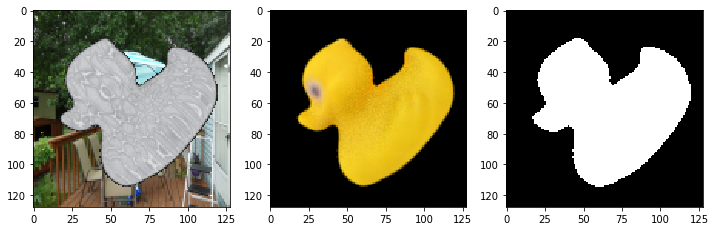

In [10]:
# Get specific test images
test_data_A, test_data_B, test_data_mask = test_data.__getitem__(30) # Convert to 4d tensor (BxNxHxW)
test_data_A = test_data_A.unsqueeze(0)
test_data_B = test_data_B.unsqueeze(0)

test_data_A = ((test_data_A - test_data_A.min()) / (test_data_A.max() - test_data_A.min()))
test_data_B = ((test_data_B - test_data_B.min()) / (test_data_B.max() - test_data_B.min()))

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(test_data_A[0].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(test_data_B[0].permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(test_data_mask[0],'gray')

# Optimization

In [11]:
#shape invariant mean square error loss
def si_mse_loss(input, target):
    loss1 = ((input-target)**2).sum()/(input.view(-1).size()[0])
    loss2 = (((input-target).sum())**2)/((input.view(-1).size()[0])**2)
    loss = loss1 - loss2
    
    return loss
    
net_g = generator(params['ngf'])
net_g.weight_init(mean=0.0, std=0.02)
net_g = nn.DataParallel(net_g)
net_g.to(device)

net_d = discriminator(params['ndf'])
net_d.weight_init(mean=0.0, std=0.02)
net_d = nn.DataParallel(net_d)
net_d.to(device)

criterionGAN = GANLoss().to(device)

# setup optimizer
optimizer_g = optim.Adam(net_g.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
optimizer_d = optim.Adam(net_d.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

# Visualization

In [12]:
def visualization(model, test_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
            transforms.Resize(size=params['input_size']),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])     

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    out = model(image)
    out = to_np(out)
    out = out.squeeze()
    result = (((out - out.min()) * 255) / (out.max() - out.min())).transpose(1, 2, 0).astype(np.uint8)
    
    test_image = plt.imread(test_path)
    plt.figure(figsize=(8,8))
    display_list = [test_image, result]
    title = ['Input Image', 'Predicted Image']
       
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

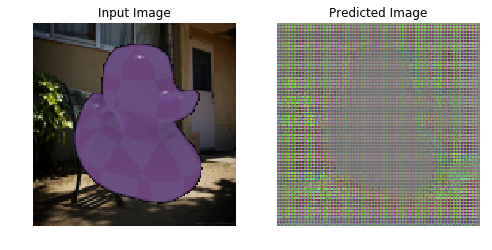

In [13]:
test_path = params['dataroot']+'/train/domainA/00001.png'
visualization(net_g, test_path)

# Training

In [14]:
checkpoint_path = './checkpoints_pix2pix_duck_blender2_pmse'

In [ ]:
train_avg_gen_losses = []
val_avg_gen_losses = []
train_avg_disc_losses = []
val_avg_disc_losses = []

for epoch in range(params['epoch_count'], params['epochs'] + 1):
    # train
    net_g.to(device).train()
    net_d.to(device).train()
    
    train_gen_losses = []
    val_gen_losses = []
    train_disc_losses = []
    val_disc_losses = []
    
    for iteration, batch in enumerate(train_data_loader, 1):
        # forward
        real_a, real_b, real_mask = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        fake_b = net_g(real_a)
        real_mask_reverse = torch.ones(1,params['input_size'],params['input_size']).to(device) - real_mask
    
        ######################
        # (1) Update D network
        ######################

        optimizer_d.zero_grad()
        
        # train with fake
        #fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(real_a, fake_b)
        loss_d_fake = criterionGAN(pred_fake, False)

        # train with real
        #real_ab = torch.cat((real_a, real_b), 1)
        pred_real = net_d.forward(real_a, real_b)
        loss_d_real = criterionGAN(pred_real, True)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        loss_d.backward(retain_graph=True)  
        optimizer_d.step()

        ######################
        # (2) Update G network
        ######################

        optimizer_g.zero_grad()

        # First, G(A) should fake the discriminator
        #fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(real_a, fake_b)
        loss_g_gan = criterionGAN(pred_fake, True)

        # Second, G(A) = B
        #pmse loss
        multiply = torch.mul(fake_b, real_mask)
        multiply2 = torch.mul(fake_b, real_mask_reverse)        
        
        real_b1 = torch.mul(real_b, real_mask)
        real_b2 = torch.mul(real_b, real_mask_reverse)
        
        loss1 = si_mse_loss(multiply, real_b1)
        loss2 = si_mse_loss(multiply2, real_b2)
        
        pmse_loss = loss1*params['alpha'] + loss2
        
        loss_g_l1 = pmse_loss * params['lamb']
        
        #gen loss
        loss_g = loss_g_gan + loss_g_l1      
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        
        # loss values
        train_disc_losses.append(loss_d.item())
        train_gen_losses.append(loss_g.item())

        if iteration % params['log_interval'] == 0:
            print("===> Epoch[{}/{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
                epoch, params['epochs'],iteration, len(train_data_loader), loss_d.item(), loss_g.item()))
    
    # avg loss values for plot
    train_avg_gen_loss = torch.mean(torch.FloatTensor(train_gen_losses))
    train_avg_disc_loss = torch.mean(torch.FloatTensor(train_disc_losses))
    
    train_avg_gen_losses.append(train_avg_gen_loss.item())
    train_avg_disc_losses.append(train_avg_disc_loss.item())
    
    with torch.no_grad():
        for iteration, batch in enumerate(val_data_loader, 1):
            real_a, real_b = batch[0].to(device), batch[1].to(device)
            fake_b = net_g(real_a)
            real_mask_reverse = torch.ones(1,params['input_size'],params['input_size']).to(device) - real_mask
            
            #fake_ab = torch.cat((real_a, fake_b), 1)
            pred_fake = net_d(real_a, fake_b)
            loss_d_fake = criterionGAN(pred_fake, False)            
            
            #real_ab = torch.cat((real_a, real_b), 1)
            pred_real = net_d.forward(real_a, real_b)
            loss_d_real = criterionGAN(pred_real, True)
            
            loss_d = (loss_d_fake + loss_d_real) * 0.5
            
            loss_g_gan = criterionGAN(pred_fake, True)
            
            #pmse loss
            multiply = torch.mul(fake_b, real_mask)
            multiply2 = torch.mul(fake_b, real_mask_reverse)        

            real_b1 = torch.mul(real_b, real_mask)
            real_b2 = torch.mul(real_b, real_mask_reverse)

            loss1 = si_mse_loss(multiply, real_b1)
            loss2 = si_mse_loss(multiply2, real_b2)

            pmse_loss = loss1*params['alpha'] + loss2
            
            loss_g_l1 = pmse_loss * params['lamb']
            
            #gen loss
            loss_g = loss_g_gan + loss_g_l1
            
            val_disc_losses.append(loss_d.item())
            val_gen_losses.append(loss_g.item())       
    
    # avg loss values for plot
    val_avg_gen_loss = torch.mean(torch.FloatTensor(val_gen_losses))
    val_avg_disc_loss = torch.mean(torch.FloatTensor(val_disc_losses))
    
    val_avg_gen_losses.append(val_avg_gen_loss.item())
    val_avg_disc_losses.append(val_avg_disc_loss.item())
    
    print("Val_Loss_D: {:.4f} Val_Loss_G: {:.4f}".format(val_avg_disc_loss.item(), val_avg_gen_loss.item()))
    
    # Show result for test image
    test_A = test_data_A.cuda()
    test_B = test_data_B.cuda()
    fake_B = net_g(test_A)
    
    plot_train_result([test_A, test_B, fake_B], epoch, save=False)
    
    # Save weight
    if epoch % 2 == 0:
        torch.save(net_g.state_dict(), checkpoint_path+'/net_g-%s.pt'%epoch)
        torch.save(net_d.state_dict(), checkpoint_path+'/net_d-%s.pt'%epoch)
    
    # Plot loss
    if epoch % 10 == 0:
        plt.figure(figsize=(10,10))
        plt.subplot(2,1,1)
        plt.plot(train_avg_gen_losses, label='train')
        plt.plot(val_avg_gen_losses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Generator_Loss')
        plt.legend()

        plt.subplot(2,1,2)
        plt.plot(train_avg_disc_losses, label='train')
        plt.plot(val_avg_disc_losses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Discriminator_Loss')
        plt.legend()

# Loss Curve

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(train_avg_gen_losses, label='train')
plt.plot(val_avg_gen_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Generator_Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(train_avg_disc_losses, label='train')
plt.plot(val_avg_disc_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Discriminator_Loss')
plt.legend()

In [35]:
np.array(val_avg_gen_losses).argmin()

397

# Restore Checkpoint

In [24]:
weight_dict = torch.load(checkpoint_path+'/net_g-384.pt')

In [25]:
net_g.load_state_dict(weight_dict)

<All keys matched successfully>

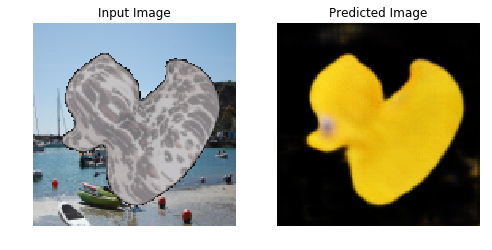

In [22]:
test_path = params['dataroot']+'/test/domainA/00021.png'
visualization(net_g, test_path)

In [ ]:
test_paths = glob('C:/Users/IVCL/Desktop/duck/real/test/image/*.png')
i = 0
for path in test_paths:
    i = i+1
    print('num_image :',i)
    visualization(net_g, path)